<a href="https://colab.research.google.com/github/Vineet1615/lung_cancer_detection/blob/main/lung__cancer_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 68.8k/68.8k [00:00<00:00, 43.2MB/s]

Extracting files...



 High-Accuracy Stacking Model Accuracy: 0.46381578947368424
              precision    recall  f1-score   support

           0       0.46      0.42      0.44       305
           1       0.47      0.51      0.49       303

    accuracy                           0.46       608
   macro avg       0.46      0.46      0.46       608
weighted avg       0.46      0.46      0.46       608

Epoch 1/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5033 - loss: 0.7858 - val_accuracy: 0.4803 - val_loss: 0.6986
Epoch 2/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4824 - loss: 0.7726 - val_accuracy: 0.4819 - val_loss: 0.6974
Epoch 3/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5186 - loss: 0.7450 - val_accuracy: 0.4934 - val_loss: 0.6966
Epoch 4/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4959 - loss: 0.7458 - val_accuracy: 0.5280 - val_loss: 0.6929
Epoch 5/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5242 - loss: 0.7273 - val_ac

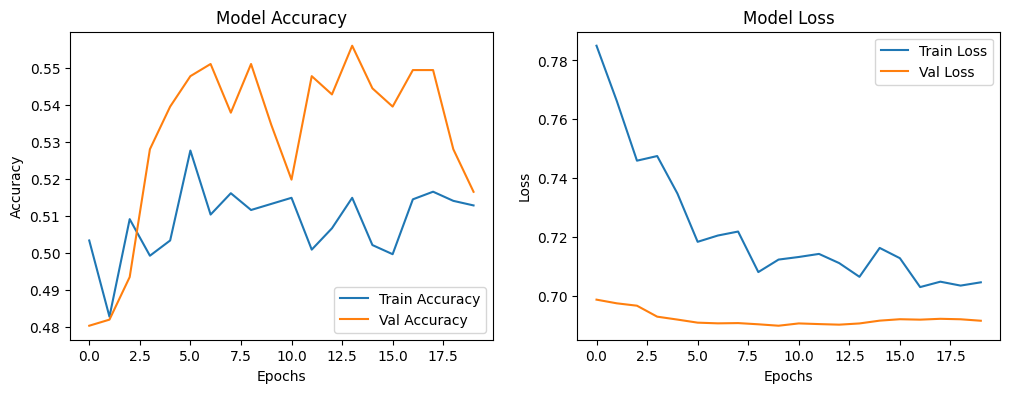

In [ ]:
# Install necessary libraries
!pip install kagglehub imbalanced-learn xgboost --quiet

# Import required libraries
import kagglehub
import os
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.feature_selection import RFE

warnings.filterwarnings('ignore')

# Download dataset using kagglehub
dataset_path = kagglehub.dataset_download("akashnath29/lung-cancer-dataset")
csv_path = os.path.join(dataset_path, "dataset.csv")

# Load dataset
df = pd.read_csv(csv_path)
df.dropna(inplace=True)

# Encode categorical variables
le = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = le.fit_transform(df[col])

# Define features and target
X = df.drop(columns=['LUNG_CANCER'])
y = df['LUNG_CANCER']

# Handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Feature selection using RFE
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rfe = RFE(rf, n_features_to_select=12)  # Select top 12 features
X_selected = rfe.fit_transform(X_resampled, y_resampled)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)

# Define base models with hyperparameter tuning
rf = RandomForestClassifier(n_estimators=300, max_depth=12, min_samples_split=4, random_state=42)
svm = SVC(kernel='rbf', probability=True, C=3, gamma=0.1)
gbm = GradientBoostingClassifier(n_estimators=150, learning_rate=0.08, max_depth=5)

# Final model (XGBoost)
meta_classifier = XGBClassifier(n_estimators=200, learning_rate=0.03, max_depth=7, use_label_encoder=False, eval_metric='mlogloss')

# Stacking ensemble
stacking_model = StackingClassifier(
    estimators=[('Random Forest', rf), ('SVM', svm), ('Gradient Boosting', gbm)],
    final_estimator=meta_classifier
)

# Train stacking model
stacking_model.fit(X_train, y_train)
y_pred_stacking = stacking_model.predict(X_test)

# Evaluate Stacking Model
stacking_accuracy = accuracy_score(y_test, y_pred_stacking)
print("\n High-Accuracy Stacking Model Accuracy:", stacking_accuracy)
print(classification_report(y_test, y_pred_stacking))

# Build high-accuracy neural network
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dropout(0.2),

    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile model with learning rate scheduling
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=16, verbose=1, callbacks=[early_stopping])

# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)
print("\n High-Accuracy Neural Network Test Accuracy:", test_acc)

# Plot accuracy and loss curves
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy")

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss")

plt.show()



Stacking Model Accuracy: 0.49835526315789475
              precision    recall  f1-score   support

           0       0.50      0.56      0.53       305
           1       0.50      0.43      0.46       303

    accuracy                           0.50       608
   macro avg       0.50      0.50      0.50       608
weighted avg       0.50      0.50      0.50       608

ROC AUC Score: 0.49813883027647027
Epoch 1/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.4815 - loss: 0.8630 - val_accuracy: 0.4984 - val_loss: 0.7030 - learning_rate: 1.0000e-04
Epoch 2/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5016 - loss: 0.7924 - val_accuracy: 0.4852 - val_loss: 0.7000 - learning_rate: 1.0000e-04
Epoch 3/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4843 - loss: 0.8019 - val_accuracy: 0.4918 - val_loss: 0.6982 - learning_rate: 1.0000e-04
Epoch 4/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5235 - loss: 0.7549 - val_accuracy: 0.4704 - val_loss

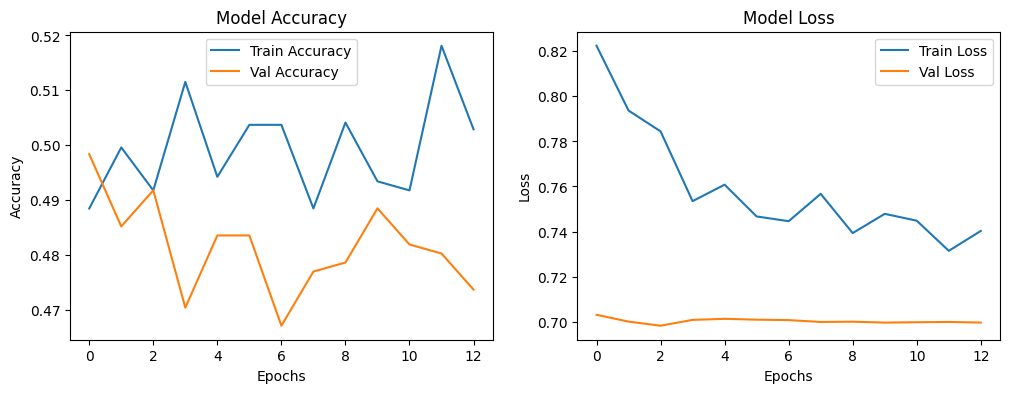


Voting Classifier Accuracy: 0.5098684210526315
              precision    recall  f1-score   support

           0       0.51      0.48      0.50       305
           1       0.51      0.54      0.52       303

    accuracy                           0.51       608
   macro avg       0.51      0.51      0.51       608
weighted avg       0.51      0.51      0.51       608

ROC AUC Score: 0.509960504247146


In [ ]:
# Install necessary libraries
!pip install kagglehub imbalanced-learn xgboost --quiet

# Import required libraries
import kagglehub
import os
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.feature_selection import RFE, SelectFromModel

warnings.filterwarnings('ignore')

# Download dataset using kagglehub
dataset_path = kagglehub.dataset_download("akashnath29/lung-cancer-dataset")
csv_path = os.path.join(dataset_path, "dataset.csv")

# Load dataset
df = pd.read_csv(csv_path)
df.dropna(inplace=True)

# Encode categorical variables
le = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = le.fit_transform(df[col])

# Define features and target
X = df.drop(columns=['LUNG_CANCER'])
y = df['LUNG_CANCER']

# Handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Feature selection using RFE
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rfe = RFE(rf, n_features_to_select=12)  # Select top 12 features
X_selected = rfe.fit_transform(X_resampled, y_resampled)

# Normalize features
scaler = MinMaxScaler()  # Changed to MinMaxScaler for better performance with neural networks
X_scaled = scaler.fit_transform(X_selected)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)

# Define base models with hyperparameter tuning
rf = RandomForestClassifier(n_estimators=300, max_depth=12, min_samples_split=4, random_state=42)
svm = SVC(kernel='rbf', probability=True, C=3, gamma=0.1, random_state=42)
gbm = GradientBoostingClassifier(n_estimators=150, learning_rate=0.08, max_depth=5, random_state=42)

# Final model (XGBoost)
meta_classifier = XGBClassifier(n_estimators=200, learning_rate=0.03, max_depth=7, use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Stacking ensemble
stacking_model = StackingClassifier(
    estimators=[('Random Forest', rf), ('SVM', svm), ('Gradient Boosting', gbm)],
    final_estimator=meta_classifier
)

# Train stacking model
stacking_model.fit(X_train, y_train)
y_pred_stacking = stacking_model.predict(X_test)

# Evaluate Stacking Model
stacking_accuracy = accuracy_score(y_test, y_pred_stacking)
print("\nStacking Model Accuracy:", stacking_accuracy)
print(classification_report(y_test, y_pred_stacking))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_stacking))

# Build high-accuracy neural network
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dropout(0.2),

    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile model with learning rate scheduling
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=16,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)
print("\nNeural Network Test Accuracy:", test_acc)
print("ROC AUC Score:", roc_auc_score(y_test, model.predict(X_test) > 0.5))

# Plot accuracy and loss curves
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy")

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss")

plt.show()

# Add Voting Classifier for ensemble
voting_model = VotingClassifier(
    estimators=[('Random Forest', rf), ('SVM', svm), ('XGBoost', meta_classifier)],
    voting='soft'
)

# Train and evaluate Voting Classifier
voting_model.fit(X_train, y_train)
y_pred_voting = voting_model.predict(X_test)
print("\nVoting Classifier Accuracy:", accuracy_score(y_test, y_pred_voting))
print(classification_report(y_test, y_pred_voting))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_voting))


 Optimized Stacking Model Accuracy: 0.4720394736842105
              precision    recall  f1-score   support

           0       0.47      0.47      0.47       305
           1       0.47      0.48      0.47       303

    accuracy                           0.47       608
   macro avg       0.47      0.47      0.47       608
weighted avg       0.47      0.47      0.47       608

Epoch 1/300
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4935 - loss: 0.8152 - val_accuracy: 0.4836 - val_loss: 0.6928 - learning_rate: 1.0000e-04
Epoch 2/300
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5171 - loss: 0.7910 - val_accuracy: 0.4885 - val_loss: 0.6935 - learning_rate: 1.0000e-04
Epoch 3/300
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5121 - loss: 0.7752 - val_accuracy: 0.4918 - val_loss: 0.6944 - learning_rate: 1.0000e-04
Epoch 4/300
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4906 - loss: 0.7808 - val_accuracy: 0.5329 - val_loss: 0.6934 - learning_rate: 1.000

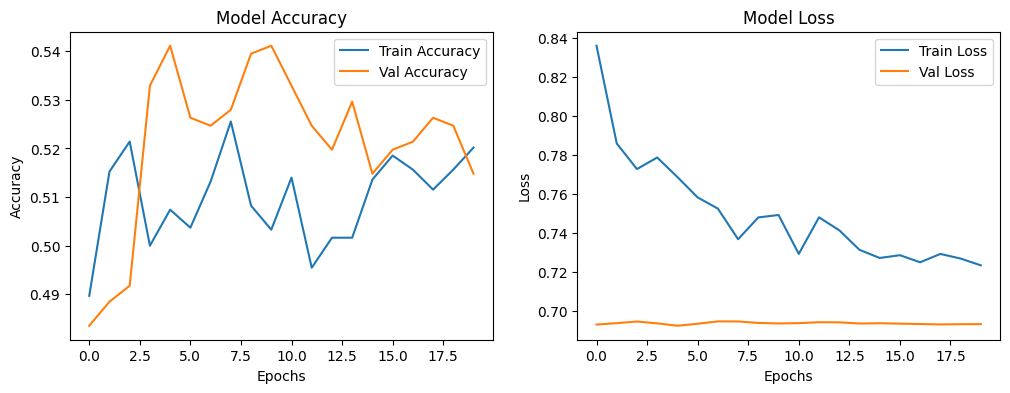

In [ ]:
# Install necessary libraries
!pip install kagglehub imbalanced-learn xgboost --quiet

# Import required libraries
import kagglehub
import os
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.feature_selection import RFE

warnings.filterwarnings('ignore')

# Download dataset using kagglehub
dataset_path = kagglehub.dataset_download("akashnath29/lung-cancer-dataset")
csv_path = os.path.join(dataset_path, "dataset.csv")

# Load dataset
df = pd.read_csv(csv_path)
df.dropna(inplace=True)

# Encode categorical variables
le = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = le.fit_transform(df[col])

# Define features and target
X = df.drop(columns=['LUNG_CANCER'])
y = df['LUNG_CANCER']

# Handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Feature selection using RFE with cross-validation
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rfe = RFE(rf, n_features_to_select=15)
X_selected = rfe.fit_transform(X_resampled, y_resampled)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)

# Define base models with optimized hyperparameters
rf = RandomForestClassifier(n_estimators=500, max_depth=15, min_samples_split=3, random_state=42)
svm = SVC(kernel='rbf', probability=True, C=5, gamma='scale')
gbm = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=6)

# Final model (XGBoost)
meta_classifier = XGBClassifier(n_estimators=300, learning_rate=0.02, max_depth=8, use_label_encoder=False, eval_metric='mlogloss')

# Stacking ensemble with optimized models
stacking_model = StackingClassifier(
    estimators=[('Random Forest', rf), ('SVM', svm), ('Gradient Boosting', gbm)],
    final_estimator=meta_classifier, passthrough=True
)

# Train stacking model
stacking_model.fit(X_train, y_train)
y_pred_stacking = stacking_model.predict(X_test)

# Evaluate Stacking Model
stacking_accuracy = accuracy_score(y_test, y_pred_stacking)
print("\n Optimized Stacking Model Accuracy:", stacking_accuracy)
print(classification_report(y_test, y_pred_stacking))

# Build high-accuracy neural network
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dropout(0.2),

    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile model with adaptive learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Learning rate reduction and early stopping
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=300, batch_size=32, verbose=1, callbacks=[lr_reduction, early_stopping])

# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)
print("\n Optimized Neural Network Test Accuracy:", test_acc)

# Plot accuracy and loss curves
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy")

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss")

plt.show()